# APS360 Group Project

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from train import train_net, train_auto_encoder, init_device, test_net
from graph import plot_training_curve, generate_confusion_matrix, visualize_output, visualize_autoencoder_output

In [2]:
init_device()

Cuda Available: True


## Baseline Model

In [3]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__() 
        self.conv1 = nn.Conv2d(1, 5, 3) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 3)
        self.conv3 = nn.Conv2d(10, 20, 3)
        self.fc = nn.Linear(26*26*20, 10)

    def forward(self, x, training=False):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 26*26*20)

        x = self.fc(x)

        return x


In [11]:
train_net(BaselineModel, "baseline_model", learning_rate=0.01, num_epochs=15)

Done Loading Data
Starting Training
Epoch 1: Train err: 0.3009833333333333, Train loss: 0.7486011400056292 | Validation err: 0.0671, Validation loss: 0.19139483333772914
Epoch 2: Train err: 0.07016666666666667, Train loss: 0.2244053818881194 | Validation err: 0.03005, Validation loss: 0.08521679673747272
Epoch 3: Train err: 0.026983333333333335, Train loss: 0.07813808476842289 | Validation err: 0.0249, Validation loss: 0.07080170450803296
Epoch 4: Train err: 0.0234, Train loss: 0.09887823923878165 | Validation err: 0.0155, Validation loss: 0.047278509049670424
Epoch 5: Train err: 0.0074, Train loss: 0.022917719834274663 | Validation err: 0.0133, Validation loss: 0.038858871806151926
Epoch 6: Train err: 0.015933333333333334, Train loss: 0.06256293324905801 | Validation err: 0.01735, Validation loss: 0.053792092987709934


KeyboardInterrupt: 

## Primary Model

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 2, 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 2, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, 2, 1)
        self.bn3 = nn.BatchNorm2d(128)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))    # 32 x 112 x 112
        x = self.bn2(F.relu(self.conv2(x)))    # 64 x 56 x 56
        x = self.bn3(F.relu(self.conv3(x)))    # 128 x 28 x 28

        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.conv4 = nn.ConvTranspose2d(128, 64, 3, 2, 1, 1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.ConvTranspose2d(64, 32, 3, 2, 1, 1)
        self.bn5 = nn.BatchNorm2d(32)
        self.conv6 = nn.ConvTranspose2d(32, 1, 3, 2, 1, 1)

    def forward(self, x):

        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)) )
        x = self.conv6(x)
        
        return x

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

class PrimaryModel(nn.Module):
    def __init__(self, encoder):
        super(PrimaryModel, self).__init__()
        self.encoder = encoder
        self.encoder.requires_grad_(False)
        
        self.conv1 = nn.Conv2d(1, 3, 3, 2, 1) 
        self.bn1 = nn.BatchNorm2d(3)
        self.conv2 = nn.Conv2d(3, 5, 3, 2, 1)
        self.bn2 = nn.BatchNorm2d(5)
        self.conv3 = nn.Conv2d(5, 10, 3, 2, 1)
        self.bn3 = nn.BatchNorm2d(10)

        self.conv4 = nn.Conv2d(128, 10, 1)
        self.bn4 = nn.BatchNorm2d(10)
        
        self.conv5 = nn.Conv2d(20,5,1)
        self.bn5 = nn.BatchNorm2d(5)
        
        self.fc1 = nn.Linear(5*28*28, 40)
        self.bn6 = nn.BatchNorm1d(40)
        self.fc2 = nn.Linear(40, 10)

    def forward(self, x):
        
        x1 = self.bn1(F.relu(self.conv1(x)))
        x1 = self.bn2(F.relu(self.conv2(x1)))
        x1 = self.bn3(F.relu(self.conv3(x1)))
        
        x2 = self.encoder(x)
        x2 = self.bn4(F.relu(self.conv4(x2)))
        
        x = torch.cat((x1,x2), dim=1)
        x = self.bn5(F.relu(self.conv5(x)))
                
        x = x.view(-1, 5*28*28)
        x = self.bn6(F.relu(self.fc1(x)))
        x = F.softmax(self.fc2(x), dim=1)

        return x

In [9]:
train_auto_encoder(AutoEncoder, "autoencoder", learning_rate=0.002, num_epochs=60, batch_size=16)

Done Loading Data
Starting Training
Epoch 1: Train loss: 0.09529403300086657 | Validation loss: 0.014991465076804161
Epoch 2: Train loss: 0.011475815682361524 | Validation loss: 0.0077724684067070485
Epoch 3: Train loss: 0.007180175104488929 | Validation loss: 0.005876238703727723
Epoch 4: Train loss: 0.0050710459326704345 | Validation loss: 0.0036766334287822245
Epoch 5: Train loss: 0.0037949368497356773 | Validation loss: 0.0028401689613237976
Epoch 6: Train loss: 0.003220015060156584 | Validation loss: 0.0026454776069149374
Epoch 7: Train loss: 0.0027372405050943294 | Validation loss: 0.002715668420307338
Epoch 8: Train loss: 0.002559707273108264 | Validation loss: 0.001915885642170906
Epoch 9: Train loss: 0.0021374505481993157 | Validation loss: 0.0012805895530618727
Epoch 10: Train loss: 0.0018455606006706755 | Validation loss: 0.002615339200012386
Epoch 11: Train loss: 0.0017290059408793846 | Validation loss: 0.0016118166698142885
Epoch 12: Train loss: 0.0016500239030768475 | Val

In [7]:

auto_encoder = AutoEncoder()
auto_encoder.load_state_dict(torch.load("autoencoder\\best_model"))
train_net(PrimaryModel, "primary_model", encoder=auto_encoder.encoder, learning_rate=0.0001, num_epochs=30, batch_size=32)

Done Loading Data
Starting Training
Epoch 1: Train err: 0.6042333333333333, Train loss: 2.1210822778701783 | Validation err: 0.4099, Validation loss: 1.9340534440994264
Epoch 2: Train err: 0.22521666666666668, Train loss: 1.789513911628723 | Validation err: 0.086, Validation loss: 1.6372577505111694
Epoch 3: Train err: 0.08571666666666666, Train loss: 1.611029081662496 | Validation err: 0.0551, Validation loss: 1.5588449354171754
Epoch 4: Train err: 0.05951666666666667, Train loss: 1.5586223403930664 | Validation err: 0.06115, Validation loss: 1.5425040954589844
Epoch 5: Train err: 0.045566666666666665, Train loss: 1.532593520228068 | Validation err: 0.03805, Validation loss: 1.5244344299316406
Epoch 6: Train err: 0.037316666666666665, Train loss: 1.5182114995956422 | Validation err: 0.0429, Validation loss: 1.5178301399230958
Epoch 7: Train err: 0.0338, Train loss: 1.5100716240564982 | Validation err: 0.04595, Validation loss: 1.5164403198242187
Epoch 8: Train err: 0.02865, Train loss

KeyboardInterrupt: 

# Visualization

In [13]:
# Testing
print("Baseline Model: ", end="")
test_net(BaselineModel, "baseline_model\\best_model")
print("Primary Model: ", end="")
test_net(PrimaryModel, "primary_model\\best_model", encoder_class=Encoder)

Baseline Model: Done Loading Data
Test error: 0.0122, Test loss: 0.03501419505181538
Primary Model: Done Loading Data
Test error: 0.03485, Test loss: 1.523413910227976


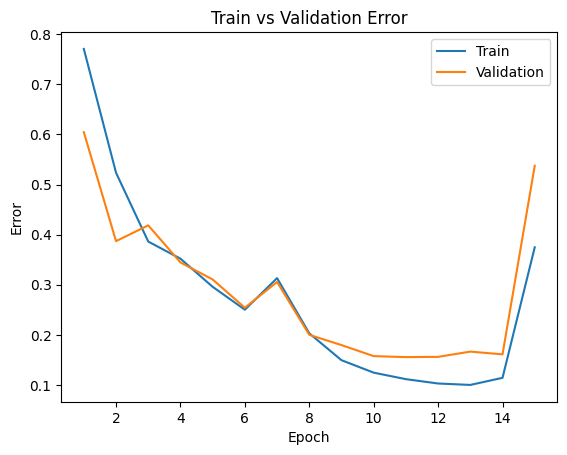

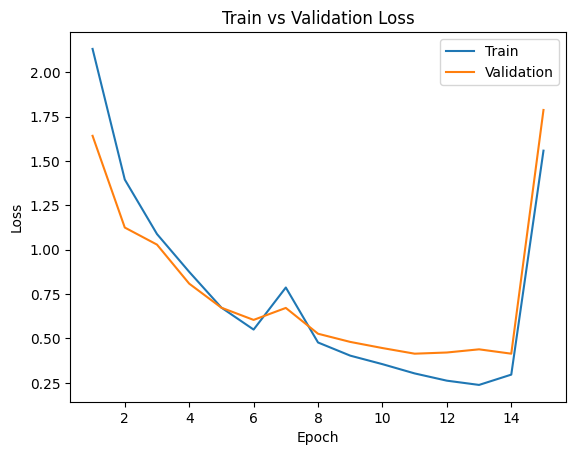

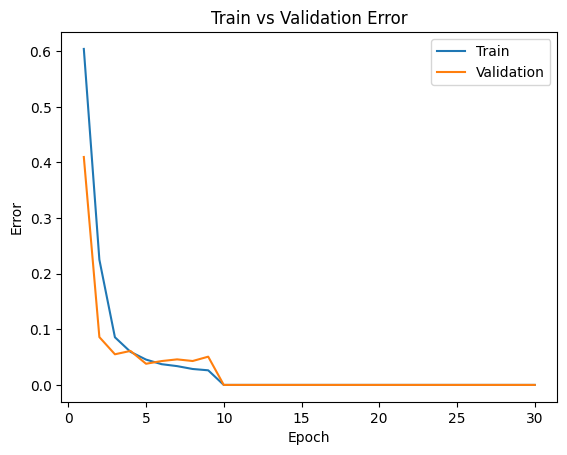

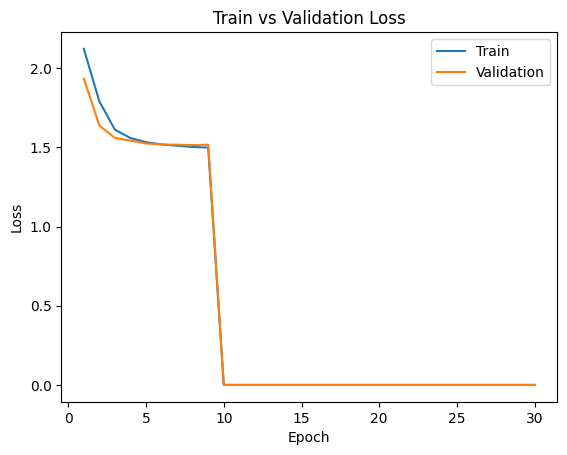

In [8]:
# Graphing
plot_training_curve("baseline_model")
plot_training_curve("primary_model")

Done Loading Data


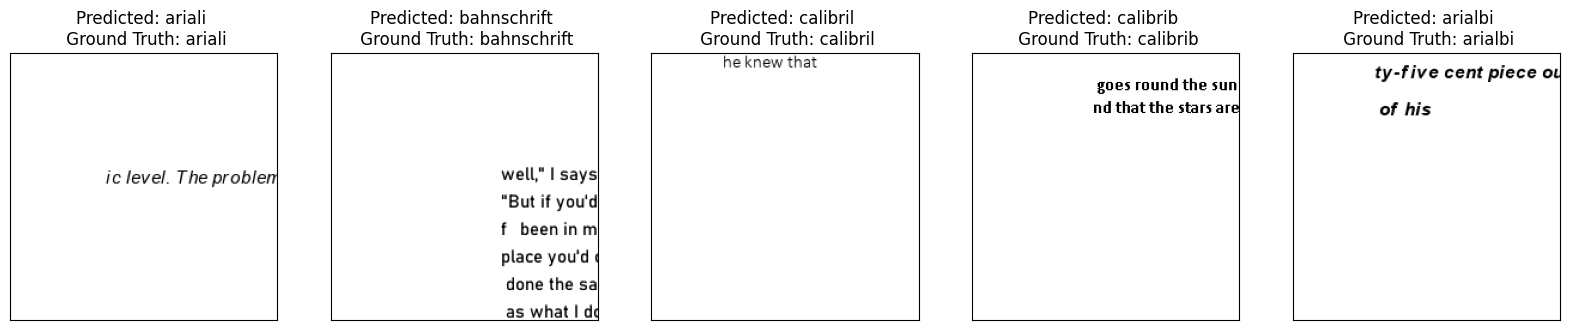

Done Loading Data


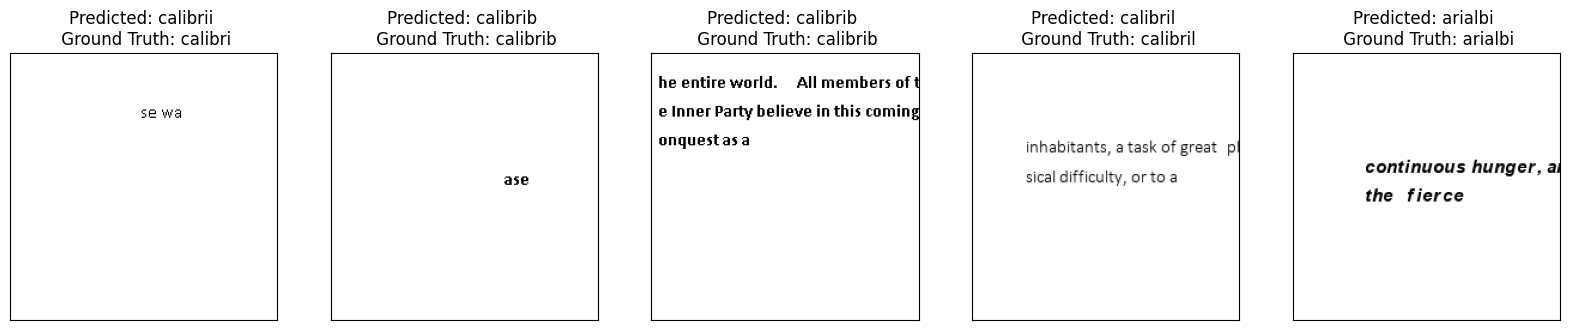

In [12]:
# Visualizing
visualize_output(5 ,"baseline_model\\best_model", BaselineModel)
visualize_output(5, "primary_model\\best_model", PrimaryModel, encoder_class=Encoder)

Done Loading Data


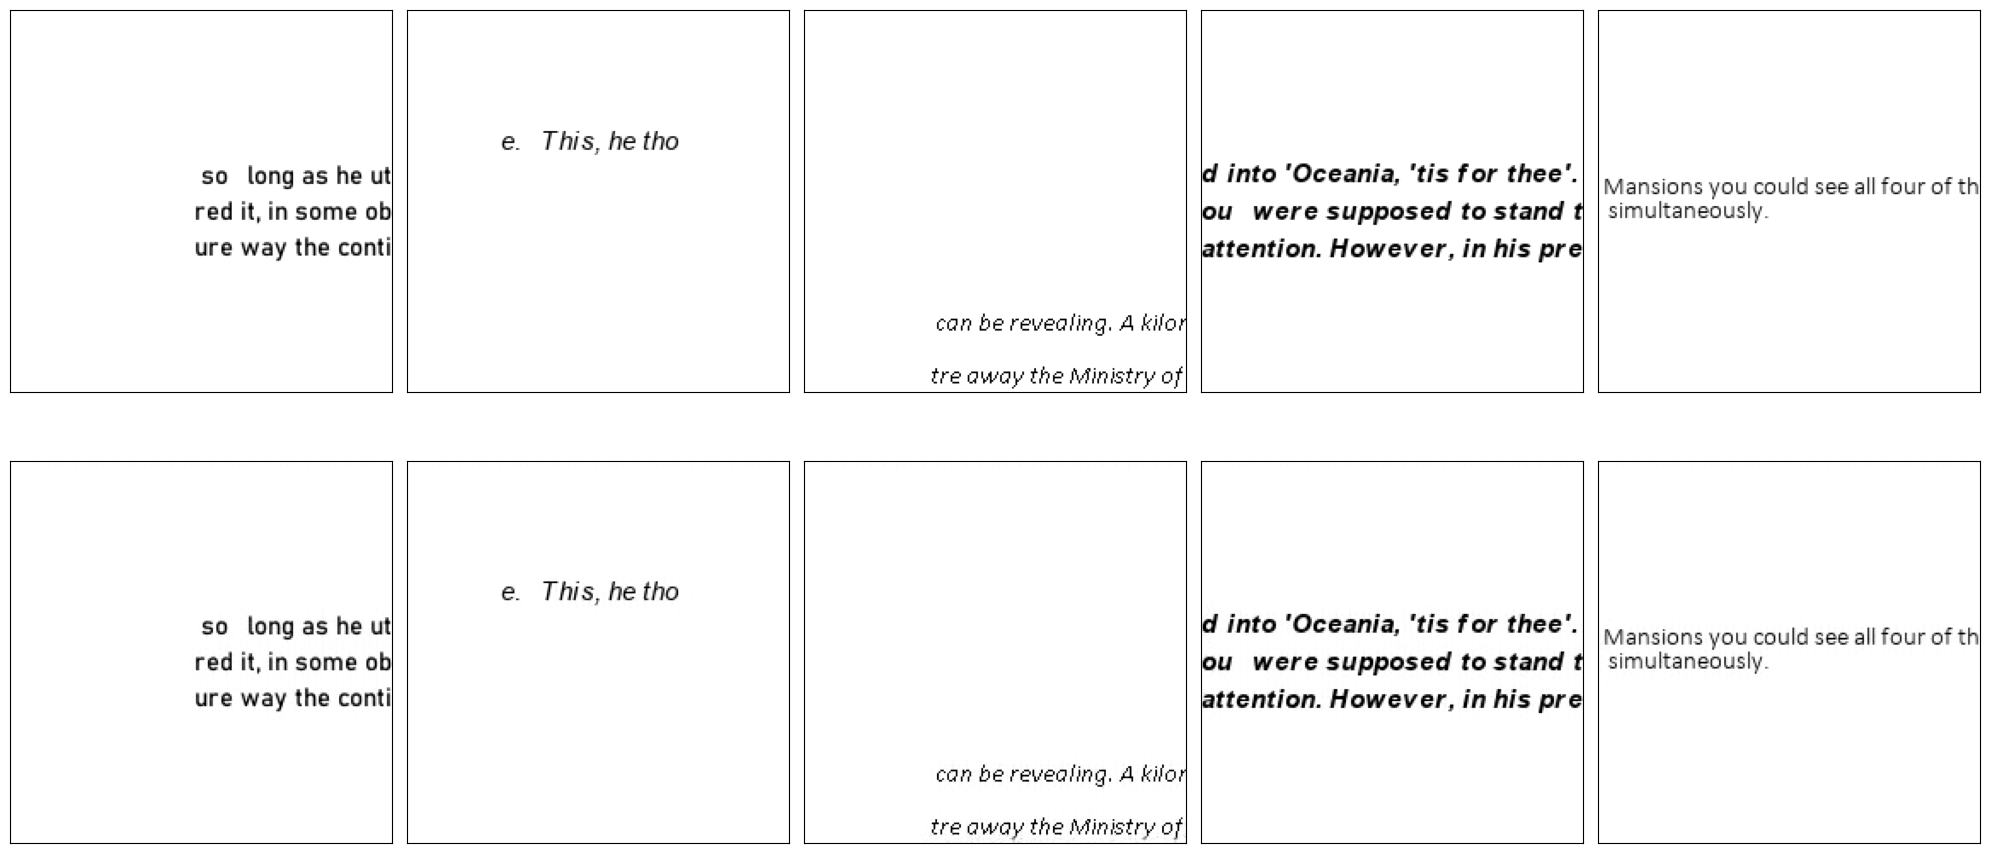

In [5]:
visualize_autoencoder_output(5, "autoencoder\\best_model", AutoEncoder)


In [ ]:
# Confusion Matrix
generate_confusion_matrix(BaselineModel, "baseline_model\\best_model")
generate_confusion_matrix(PrimaryModel, "primary_model\\best_model")